In [38]:
import disklab
from disklab import DiskRadialModel
import disklab.natconst 
from disklab.diskradial import *
from disklab.natconst import *
from snippets import *
import matplotlib.pyplot as plt
import numpy as np

# Define physical parameters for the black hole accretor and disk boundaries
MBH = 5 * MS          # Black hole mass (5 times the solar mass)
R_in  = 0.1 * AU      # Inner radius of the disk
R_out = 1 * AU        # Outer radius of the disk
m_sun = MBH / MS      # Dimensionless mass in solar units
Mdot = 0.01 * MS / year # g/s
Mdot16 = Mdot / 1e16  # Dimensionless
alpha_num = 1e-2      # Viscosity parameter

# Initialize the disk model with the specified parameters
d = DiskRadialModel(mstar = MBH, rin = R_in, rout = R_out, alpha = alpha_num)
d.make_disk_from_m_pl(mdisk=0.01 * MBH)
d.mu = 0.615

# Time setup
t_end = 2e19
ntime = 100
time_steps = t_end ** (np.linspace(0, 1, ntime + 1))

# Function definitions
def f_func(R):
    return (1 - np.sqrt(R_in / R))**(1/4)

def Sigma_analytic(R):
    return (5.2 * alpha_num**(-4/5) * Mdot16**(7/10) * m_sun**(1/4) * (R / 1e10)**(-0.75) * f_func(R)**(14/5))

def Tc_analytic(R):
    return (1.4e4 * alpha_num**(-1/5) * Mdot16**(3/10) * m_sun**(-1/4) * (R/1e10)**(-0.75) * f_func(R)**(6/5))

def rho_analytic(R):
    return (3.1e-8 * alpha_num**(-7/10) * Mdot16**(11/20) * m_sun**(-7/20) * (R/1e10)**(-15/8) * f_func(R)**(11/5))

def nu_analytic(R):
    return 1.8e14 * alpha_num**(4/5) * Mdot16**(3/10) * m_sun**(-1/4) * (R/1e10)**(0.75) * f_func(R)**(6/5)

def Hr_R_analytic(R):
    return 1.7e-2 * alpha_num**(-1/10) * Mdot16**(3/20) * m_sun**(-3/20) * (R/1e10)**(1/8) * f_func(R)**(3/5)


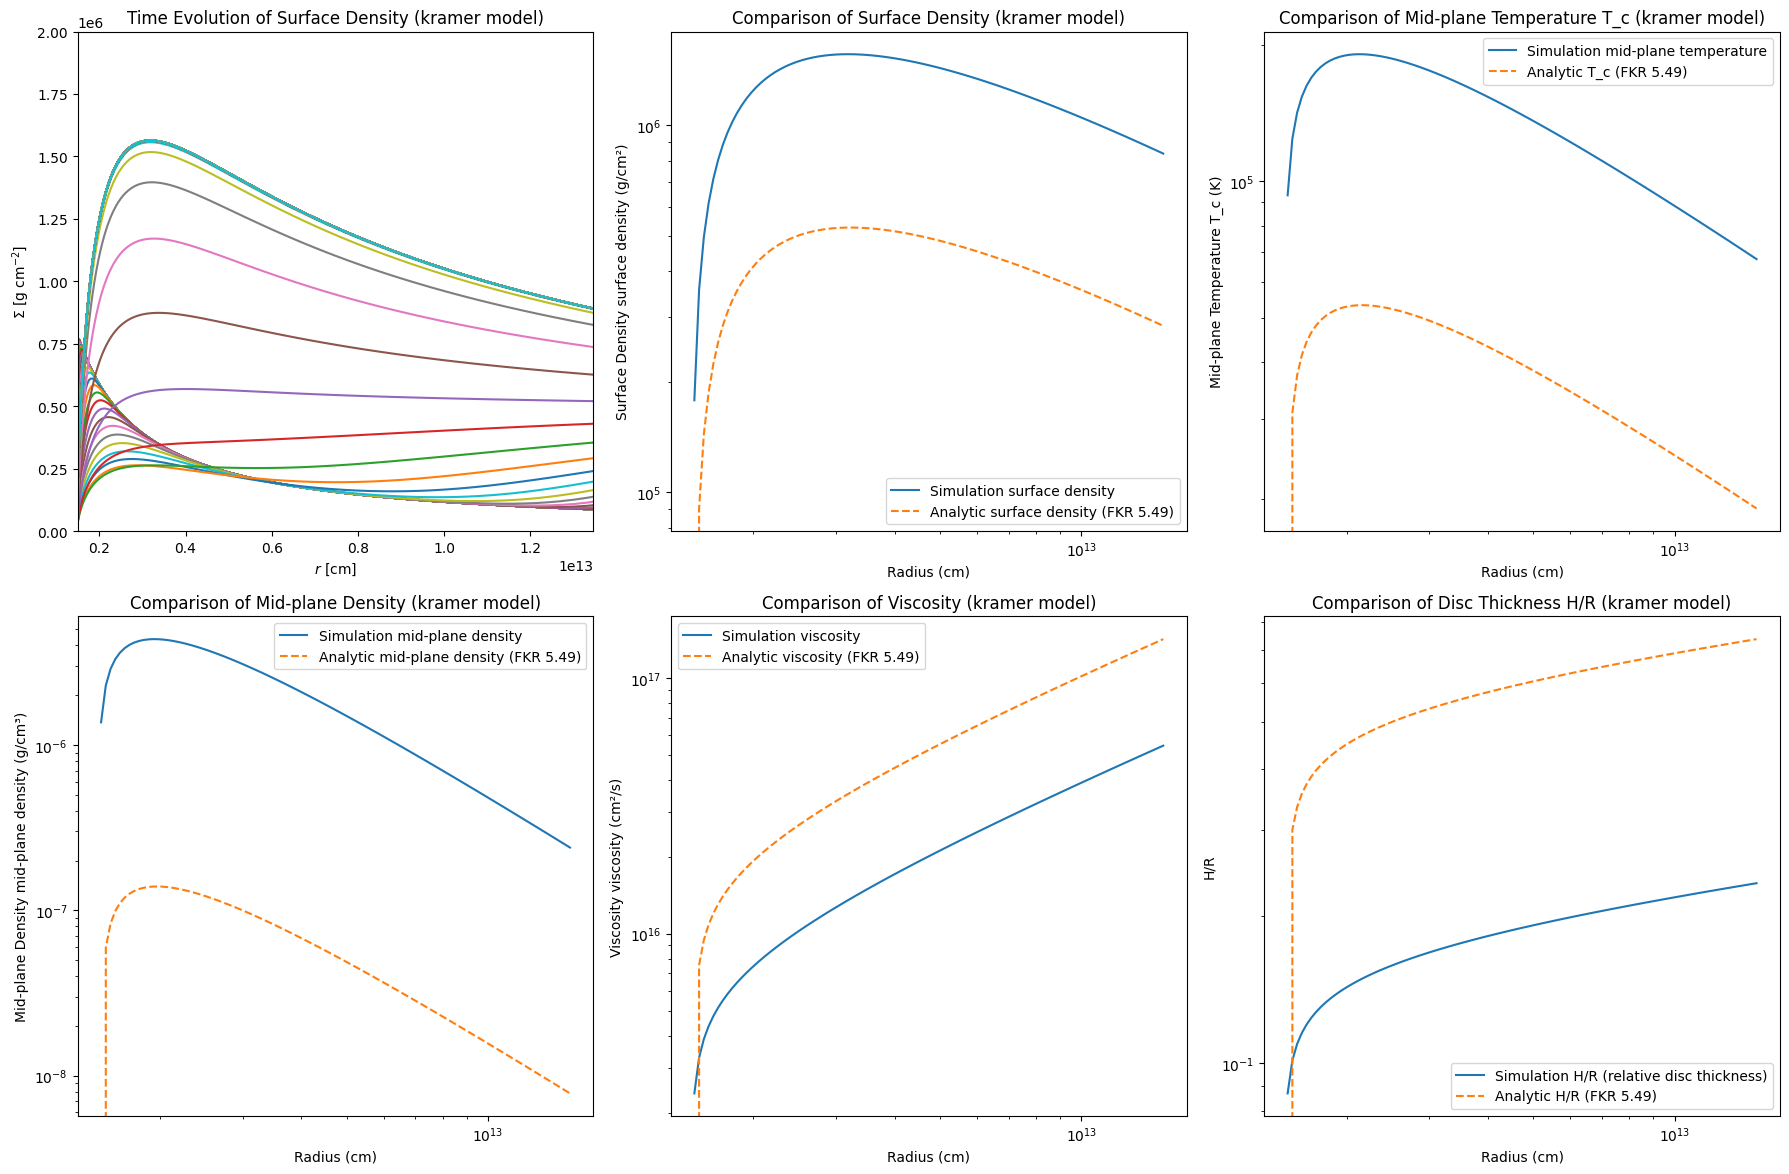

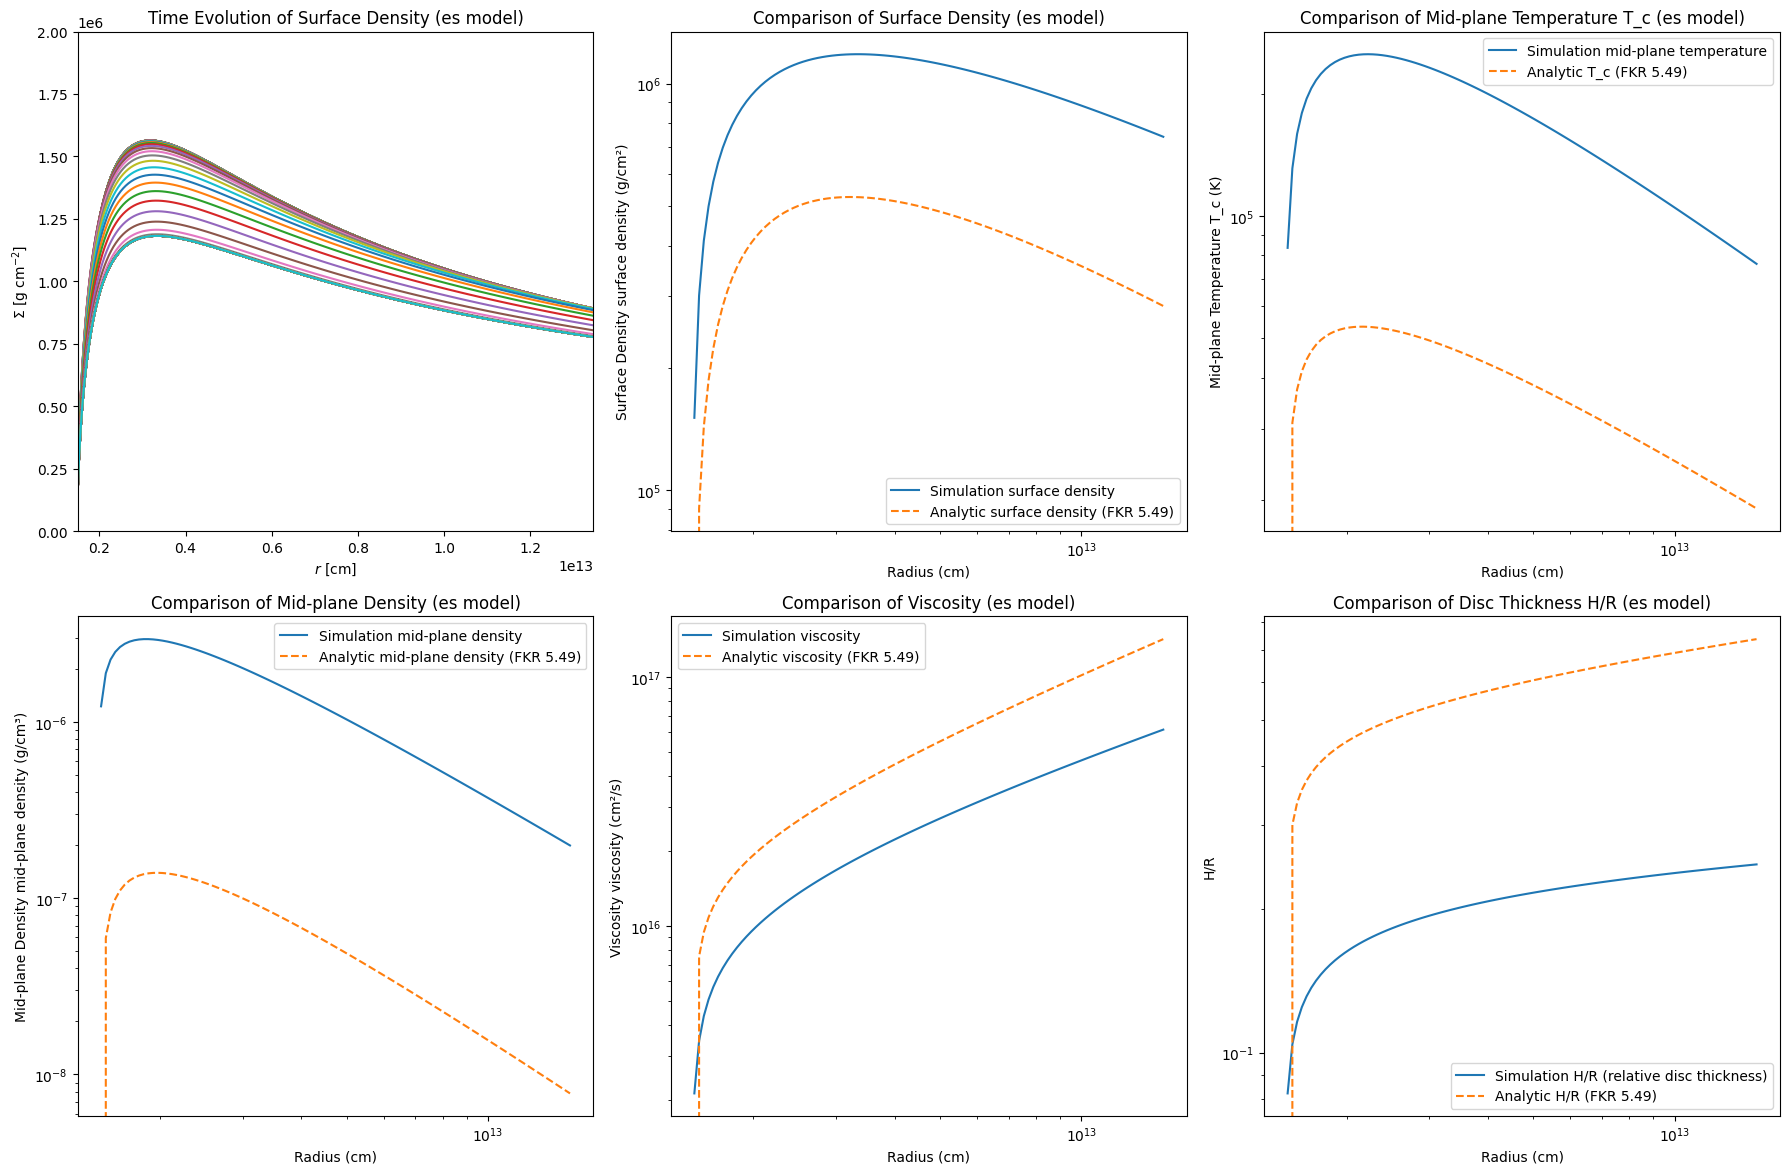

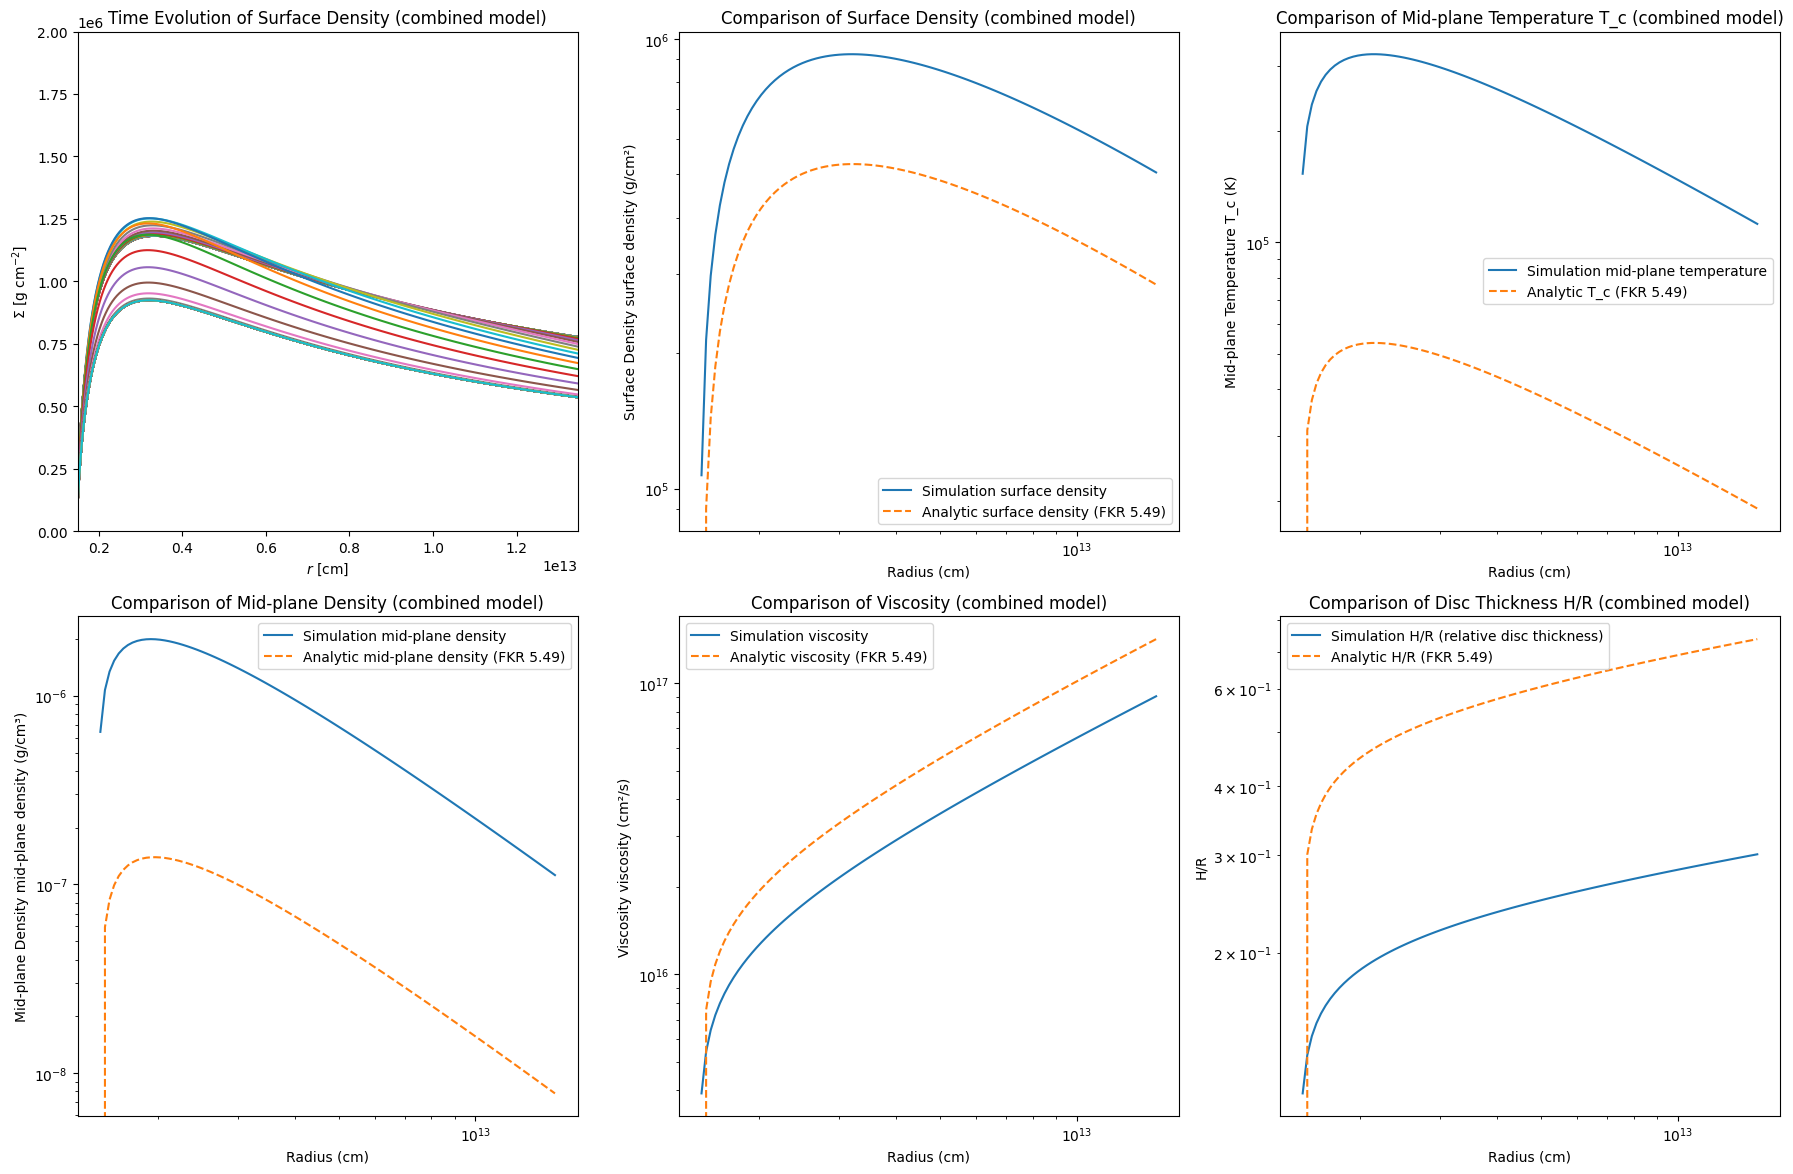

In [39]:
opacity_models = ['kramer', 'es', 'combined']

for model in opacity_models:
    d.meanopacitymodel = [model]
    d.compute_mean_opacity()
    
    fig, axs = plt.subplots(2, 3, figsize=(18, 12), dpi=100)
    
    for i in range(1, ntime + 1):
        d.compute_nu()
        d.sigma = d.get_viscous_evolution_next_timestep(time_steps[i] - time_steps[i - 1], sigma_innerbc=d.sigma[1]/2, alphamodel=True, mdot_outerbc=0.01*MS/year)
        
        d.compute_disktmid(vischeat=True, simple=True)
        d.compute_cs_and_hp()
        d.compute_rhomid_from_sigma()
        d.compute_mean_opacity()
        axs[0, 0].plot(d.r, d.sigma, label=f'Time = {time_steps[i]:.1e} s')
    
    # Plotting surface density evolution
    axs[0, 0].set_xlabel(r'$r$ [cm]')
    axs[0, 0].set_ylabel(r'$\Sigma$ [g cm$^{-2}$]')
    axs[0, 0].set_title(f'Time Evolution of Surface Density ({model} model)')
    axs[0, 0].set_xlim(0.1*AU, 0.9*AU)
    axs[0, 0].set_ylim(0, 2e6)
    
    # Plot surface density
    axs[0, 1].loglog(d.r, d.sigma, label="Simulation surface density")
    axs[0, 1].loglog(d.r, Sigma_analytic(d.r), '--', label="Analytic surface density (FKR 5.49)")
    axs[0, 1].set_xlabel("Radius (cm)")
    axs[0, 1].set_ylabel("Surface Density surface density (g/cm²)")
    axs[0, 1].legend()
    axs[0, 1].set_title(f"Comparison of Surface Density ({model} model)")

    # Plot mid-plane temperature
    axs[0, 2].loglog(d.r, d.tmid, label="Simulation mid-plane temperature")
    axs[0, 2].loglog(d.r, Tc_analytic(d.r), '--', label="Analytic T_c (FKR 5.49)")
    axs[0, 2].set_xlabel("Radius (cm)")
    axs[0, 2].set_ylabel("Mid-plane Temperature T_c (K)")
    axs[0, 2].legend()
    axs[0, 2].set_title(f"Comparison of Mid-plane Temperature T_c ({model} model)")

    # Plot mid-plane density
    axs[1, 0].loglog(d.r, d.rhomid, label="Simulation mid-plane density")
    axs[1, 0].loglog(d.r, rho_analytic(d.r), '--', label="Analytic mid-plane density (FKR 5.49)")
    axs[1, 0].set_xlabel("Radius (cm)")
    axs[1, 0].set_ylabel("Mid-plane Density mid-plane density (g/cm³)")
    axs[1, 0].legend()
    axs[1, 0].set_title(f"Comparison of Mid-plane Density ({model} model)")

    # Plot viscosity
    axs[1, 1].loglog(d.r, d.nu, label="Simulation viscosity")
    axs[1, 1].loglog(d.r, nu_analytic(d.r), '--', label="Analytic viscosity (FKR 5.49)")
    axs[1, 1].set_xlabel("Radius (cm)")
    axs[1, 1].set_ylabel("Viscosity viscosity (cm²/s)")
    axs[1, 1].legend()
    axs[1, 1].set_title(f"Comparison of Viscosity ({model} model)")

    # Plot H/R (relative disc thickness)
    axs[1, 2].loglog(d.r, d.hp/d.r, label="Simulation H/R (relative disc thickness)")
    axs[1, 2].loglog(d.r, Hr_R_analytic(d.r), '--', label="Analytic H/R (FKR 5.49)")
    axs[1, 2].set_xlabel("Radius (cm)")
    axs[1, 2].set_ylabel("H/R")
    axs[1, 2].legend()
    axs[1, 2].set_title(f"Comparison of Disc Thickness H/R ({model} model)")

    plt.tight_layout()
    plt.show()
    